<h1>An introduction to Deep AutoEncoders</h1>

In [15]:
import pickle
pickle_in = open("all_jets_train_4D_100_percent.pkl","rb")
pickle_in1 = open("all_jets_test_4D_100_percent.pkl","rb")
train = pickle.load(pickle_in)
test=pickle.load(pickle_in1)

<h2>Testing if training and testing data has been loaded properly</h2>

In [2]:
train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


In [3]:
test.head(10)

,m,pt,phi,eta
85972,4983.729980,23798.070312,1.962157,-0.059532
38742,5435.273438,21881.867188,1.035412,0.734343
128711,5239.408691,24608.134766,-1.121055,0.828848
28751,14121.240234,203110.953125,0.324205,-2.571108
131358,3344.826660,24897.294922,0.395331,1.440069
44010,4970.624023,21658.121094,-2.435544,-0.388735
20111,4642.400879,26393.455078,1.749449,-1.149457
137856,17355.609375,184078.937500,2.364634,-1.783496
87065,5070.462891,20717.832031,-1.479996,1.588451
39358,8267.166016,44952.789062,-0.580280,-0.356304


<h2>Loading libraries needed to declare our class</h2>


In [4]:
%matplotlib inline
import matplotlib as mpl
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai


<h2>Declaration of our model which will be used to train the dataset</h2>

In [5]:
## Bringing AE_3D_200 Model

import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import datetime
import time
import pandas as pd

class AE_3D_200(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'

<h2>Mathematical Operations on Data to ensure optimum results while training</h2>

In [6]:
n_features = len(train.loc[0])
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

<h2>Declaration of loss function which will be used to develop the trained model</h2>

In [7]:
train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

db = basic_data.DataBunch(train_dl, valid_dl)

model = AE_3D_200()

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

<h2>Calling the pre-trained model which shall be used</h2>

In [8]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f30e0416990>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f30e0141f10>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

<h2>Validating the model</h2>

In [9]:
learn.validate()

[0.5058878]

<h2>Using matplotlib to facilitate printing of our custom graphs</h2>

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from colorsys import hsv_to_rgb

class ms:
    def set_my_style():
        # lines
        mpl.rcParams['lines.linewidth'] = 2
        mpl.rcParams['lines.color'] = 'r'

        # axis
        mpl.rcParams['axes.titlesize'] = 26
        mpl.rcParams['axes.grid'] = True


    def sciy():
        plt.gca().ticklabel_format(style='sci', scilimits=(0, 0), axis='y')


    def scix():
        plt.gca().ticklabel_format(style='sci', scilimits=(0, 0), axis='x')


    def colorprog(i_prog, Nplots, v1=.9, v2=1., cm='hsv'):
        if hasattr(Nplots, '__len__'):
            Nplots = len(Nplots)
        if cm == 'hsv':
            return hsv_to_rgb(float(i_prog) / float(Nplots), v1, v2)
        elif cm == 'rainbow':
            return [plt.cm.rainbow(k) for k in np.linspace(0, 1, Nplots)][i_prog]
        else:
            raise ValueError('What?!')

<h2>Plotting number of events nefore and after data is fed through AutoEncoder</h2>

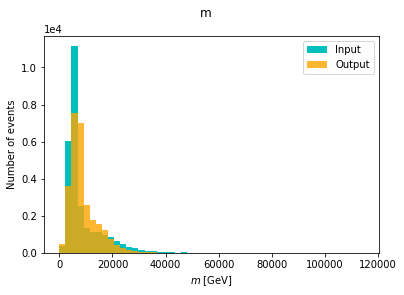

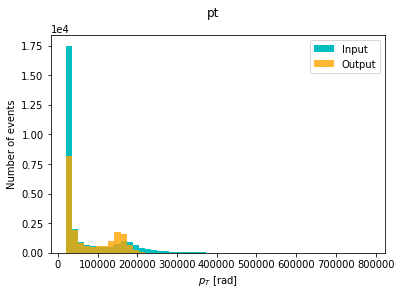

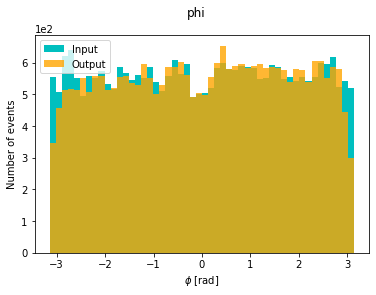

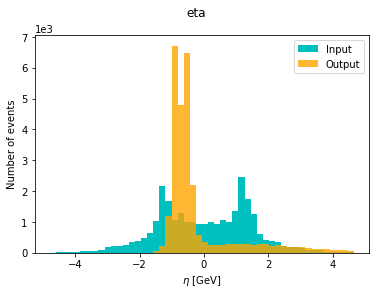

In [11]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()

<h2>Declaring standard error which shall be used in next cell</h2>

In [13]:
def std_error(x, axis=None, ddof=0):
    return np.nanstd(x, axis=axis, ddof=ddof) / np.sqrt(2 * len(x))


<h2>Plotting number of jets before and after data is fed through AutoEncoder</h2>

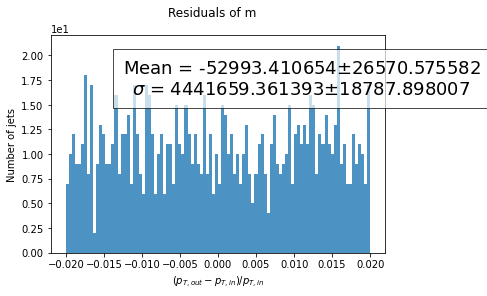

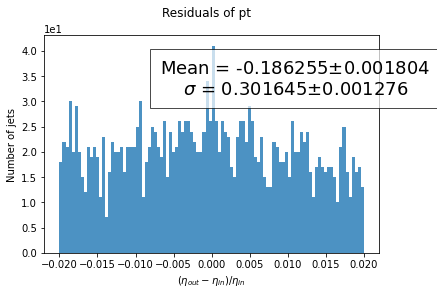

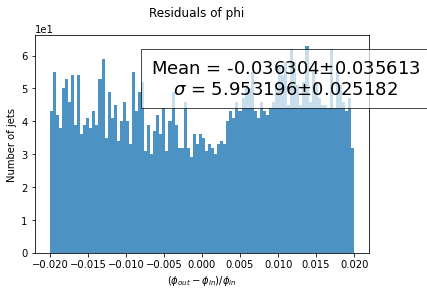

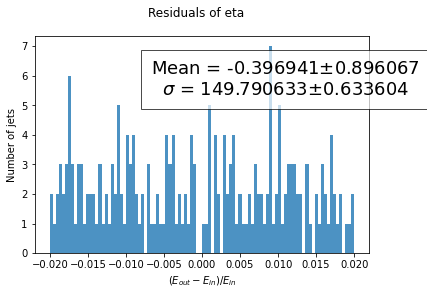

In [14]:
import utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)
#range=None
for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]